# Sparsepea Module

#### Simon Mishricky

This notebook illustrates the usage of the ```sparsepea``` module. 

This module contains two subpackages
- ```sparsepea.tools```
- ```sparsepea.models```


### ```sparsepea.tools```

This subpackage contains tool require for interpolating, solving and plotting the models found in ```sparsepea.models```. This package uses ```Tasmanian``` which is used for generating sparse grids, as well as interpolating and integrating over sparse grids. 

```sparsepea.tools``` is designed to solve models using the non-stochastic parameterised expectations algorithm as well as provide representations of the solutions and numerical errors produced

Currently ```sparsepea.tools``` contains the following methods
- ```.makes_states_grid``` which uses ```Tasmanian``` to create a multidimensional local polynomial sparse grid that represents the state space of the model being solved
- ```.makes_shocks_grid``` which uses ```Tasmanian``` to create a multidimensional local polynomial sparse grid that represents the shocks space of the model being solved, if the model contains a stochasitic process
- ```.sparse_interpolate``` which uses ```Tasmanian``` to interpolate points over the state space sparse grid constructed
- ```.euler_interpolation``` which interpolates the right hand side of any euler equation using ```.sparse_interpolate```
- ```.compute_solution``` which solves for the optimal euler equation and policy functions using the parameterised expectations algorithm
- ```.policy_function``` which generates a policy function on a regular grid, given a solution in terms of a sparse grid
- ```.plot_policy_3d``` Given that the model has two state variables, this method plots the solutions (both the sparse and regular grid versions overlaid) on a 3D axis
- ```.plot_errors_3d``` Again given the model has two state variables, this method plots the Euler residuals resulting for the algorithm
- ```.plot_errors_dist``` This method plots the distribution of the Euler residuals

### ```sparsepea.models```

This subpackage contains models that have been just in time compiled using 
```numba.experimental.jitclass```. They have been written in such a way to make them compatible with the 
```sparsepea.tools```. 

Currently ```sparsepea.models``` contains three models:
- Real Business Cycles with Irreversible Investment labelled as ```rbc_jit```
- Diamond Mortensen Pissarides with Hagedorn and Manovskii parameters labelled as ```dmp_jit```
- Endogenous Disasters labelled as ```dmp_end```

Below is an example of the implementation of this module for both models listed above

In [1]:
# Packages required
import numpy as np
import quantecon.markov as qe
from sparsepea.models import rbc_jit, dmp_jit, end_dmp_jit
from sparsepea.tools import tools

In [2]:
# Parameters for initial guess function
α = 0.33          
δ = 0.025 
y_k = 0.11210762331838565
β = 1.0 / (α * y_k + 1.0 - δ)

# Coefficients for initial guess
γ_rbc = np.array([-np.log(1 - α * β) , -α, -1])

In [3]:
# Function for initial guess
def initial_guess(grid_states, γ):
    
    grid_size = grid_states[:, 1].size
    guess = np.zeros([grid_size, 1])
    
    for i in range(grid_size):
        
        state = grid_states[i, :]
        x, y = state[0], state[1]
        
        guess[i, :] = np.exp(γ[0] + γ[1] * np.log(x) + γ[2] * np.log(y))
        
    return guess

## Real Business Cycles with Irreversible Investment

We begin by specifying the problem, the value function is:

$$v(K, Z) = \max_{K' \in \mathcal{D}_{K, Z}} u(C) + \beta \mathbb{E}\left[v(K', Z')|Z \right]$$

$$\text{s.t.}$$

$$C = Zf(K) + (1 - \delta)K - K'$$

$$\mathcal{D}_{K, Z} = \left\{K': (1 - \delta) K \leq K' \leq Zf(K) + (1 -\delta)K \right\}$$

$$\log(Z') = \rho \log(Z) + \sigma \epsilon'$$

Where $u(C) = \frac{C^{1 - \eta} - 1}{1 - \eta}$, $f(K) = K^\alpha$ and $\epsilon' \sim N(0, 1)$

The first order conditions of this program are:

$$C^{- \eta} - \mu = \beta \mathbb{E}\left[C'^{- \eta}(1 - \delta + \alpha Z'K'^{\alpha - 1}) - \mu'(1 - \delta) \right]$$

$$C = Zf(K) + (1 - \delta)K - K'$$

$$0 = \mu \left[K' - (1 - \delta)K \right]$$

$$0 \leq \mu$$

$$0 \leq K' - (1 - \delta)K$$

The last two conditions are the Karush Kuhn Tucker conditions associated with the non-negativity constraint on investment: either the constraint does not bind, in which case $\mu = 0$ or gross investment is zero, in which case $\mu \geq 0$.

The goal is to calculate

$$e(K', Z') = \beta\mathbb{E}\left[C'^{- \eta}(1 - \delta + \alpha Z'K'^{\alpha - 1}) - \mu'(1 - \delta) \right]$$

In [4]:
# Initialise an instance of the rbc model
rbc_model = rbc_jit()

# Initialise tools class given the rbc model
tool_box = tools(model=rbc_model)

# Make a sparse grid require to generate an initial guess
# These grids as well as all grids used in this notebook are order=8, depth=1, see Tasmanian
grid, grid_states = tool_box.make_states_grid()

# Generate an initial guess
e = initial_guess(grid_states, γ_rbc)

# Solve for the optimal Euler equation and consumption function
e_p, c, μ, count= tool_box.compute_solution(e)
print(count)

Convergence successful: 318 Iterations


In [5]:
%%timeit
e_p, c, μ, count = tool_box.compute_solution(e)

1min 22s ± 3.22 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### RBC speed test summary

|    Structure   | PEA algorithm|
|:-----:|:---------:|
|   ```jit``` | 53.6 sec  |
|```jitclass```| 1 min 20 sec|
| no ```jit```| 32 min 5 sec |

Listed here are three different code structures and their associated speed tests.

In a separate notebook, a speed test was conducted to check the speed difference with basic ```numba.njit``` usage and its time is recorded above (53.6 sec). Which is much faster than the same model run without using ```numba``` (32 min 5 sec) at all.

The module ```sparsepea.models``` uses ```numba.jitclass``` which solves the model in 1 min 20 sec. This is slightly slower than basic ```numba.njit``` usage. There are two main reasons for this. Firstly ```jitclass``` is still an experimental and is known to run slighlty slower than ```njit```. Second the ```njit``` experiment uses ```numba.prange``` as well as ```numba.njit```. Which allows the algorithm to be parallelised across all processors. ```numba.prange``` cannot be used with ```numba.jitclass```. Given this however, ```sparsepea``` still performs much faster than the same model without ```numba``` 

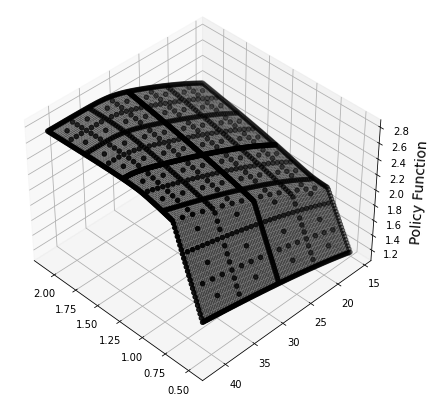

In [6]:
tool_box.plot_policy_3d(c)

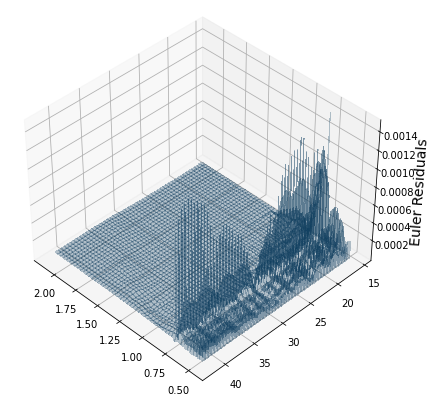

In [7]:
tool_box.plot_errors_3d(e)

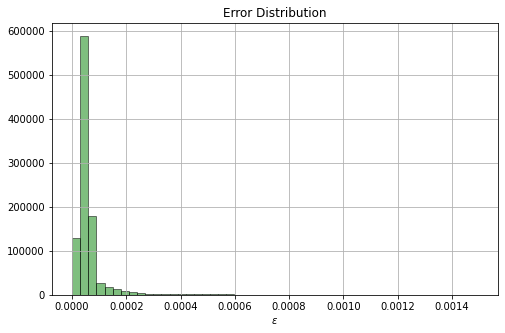

In [8]:
tool_box.plot_errors_dist()

## Diamond Mortensen Pissarides - Hagedorn Manovskii

We begin again by specifying the problem

The first order conditions are:

$$\frac{\kappa_t}{q(\theta_t)} - \lambda_t = \beta \mathbb{E}\left[\left(X_{t + 1} - W_{t + 1} \right) +(1 - s) \left(\frac{\kappa_{t + 1}}{q(\theta_{t + 1})} - \lambda_{t + 1} \right) \right]$$

$$N_{t + 1} = (1 - s)N_t + q(\theta_t)V_t$$

$$W_t = \eta \left(X_t + \kappa_t \theta_t\right) + \left(1 - \eta \right)b$$

$$\kappa_t = \kappa_K X_t + \kappa_W X_t^{\xi} \quad \kappa_K, \kappa_W, \xi >0$$

$$\ln(X_{t + 1}) = \rho \ln(X_t) + \sigma \epsilon_{t + 1} \quad \epsilon \sim N(0, 1)$$

$$\lambda_t q(\theta_t) V_t = 0$$

$$\lambda_t \geq 0$$

$$q(\theta_t)V_t \geq 0$$

The last two conditions are the Karush Kuhn Tucker conditions associated with the non-negativity constraint on investment: either the constraint does not bind, in which case $\lambda = 0$ or gross investment is zero, in which case $\lambda \geq 0$.

The goal is to calculate

$$e(X_t) = \beta \mathbb{E}\left[\left(X_{t + 1} - W_{t + 1} \right) +(1 - s) \left(\frac{\kappa_{t + 1}}{q(\theta_{t + 1})} - \lambda_{t + 1} \right) \right]$$

In [9]:
γ_dmp = np.array([-20, 23.18875328038525, 0.0])

In [10]:
def initial_guess_dmp(grid_states, γ):
    
    grid_size = grid_states[:, 1].size
    guess = np.zeros([grid_size, 1])
    
    for i in range(grid_size):
        
        state = grid_states[i, :]
        x, y = state[0], state[1]
        
        guess[i, :] = γ[0] + γ[1] * x + γ[2] * y
        
    return guess

In [11]:
# Initialise an instance of the dmp model
dmp_model = dmp_jit()

# Initialise tools class given the dmp model
tool_box = tools(model=dmp_model, max_iter=1000)
grid_dmp, grid_states_dmp = tool_box.make_states_grid()

# Make a sparse grid require to generate an initial guess
e_dmp = initial_guess_dmp(grid_states_dmp, γ_dmp)

# Solve for the optimal Euler equation and tightness function
e_p, θ, λ, count_dmp = tool_box.compute_solution(e_dmp)
print(count_dmp)

Convergence successful: 521 Iterations


In [12]:
%%timeit
e_p, θ, μ, count_dmp = tool_box.compute_solution(e_dmp)

2min 2s ± 3.13 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


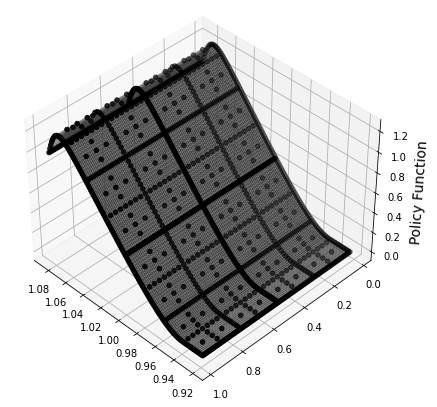

In [13]:
tool_box.plot_policy_3d(θ)

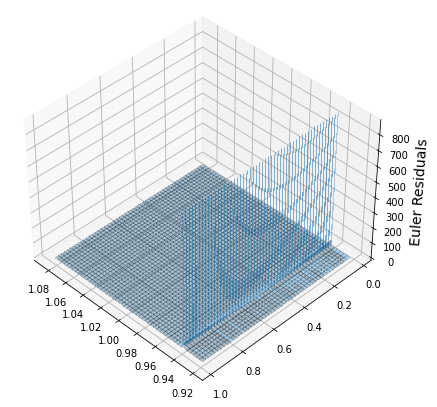

In [14]:
tool_box.plot_errors_3d(e_dmp)

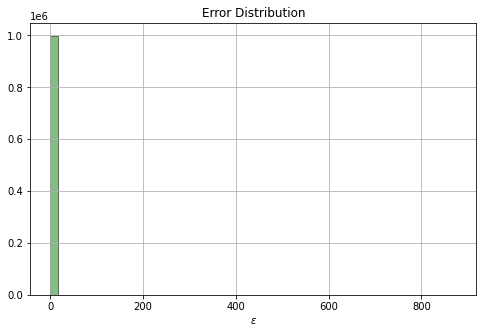

In [15]:
tool_box.plot_errors_dist()